# Quick Introduction:
Hello, this is a jupyter notebook created by Adel for the medium article {article title}. The goal of the code is to analyze the culture of a goegraphical region according to how people associated with said region tweet online. We recomend reading the article for more information. 

#### **The official summary is at the bottom of this notebook.**

# Step 2.0: Sanity Checks
Here we make sure everything loads and works as intended

In [128]:
import sys
import json
import re
import nltk
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from empath import Empath
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon (only needs to run once)
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [74]:
# Root data dirs (relative to this notebook, which lives in /notebooks)
DATA_DIR   = Path("..") / "data"
TWEETS_DIR = DATA_DIR / "tweets"
USERS_DIR  = DATA_DIR / "users"

REGIONS = ["nyc", "sg", "uk"]


# Check that the external tweet + user files we need are present
expected_files = {}

for r in REGIONS:
    expected_files[f"{r}_tweets_external"] = TWEETS_DIR / f"{r}_tweets_external.jsonl"
    expected_files[f"{r}_users_external"]  = USERS_DIR  / f"{r}_users_external.jsonl"

for name, path in expected_files.items():
    status = "OK" if path.exists() else "MISSING"
    print(f"{name:25} → {status:8} {path}")

# Quick peek at how many lines are in each tweets file
print("\nQuick line-count sanity check (tweets only):")
for r in REGIONS:
    path = TWEETS_DIR / f"{r}_tweets_external.jsonl"
    if path.exists():
        with path.open() as f:
            n_lines = sum(1 for _ in f)
        print(f"{r.upper():3} tweets: {n_lines:6d} lines")
    else:
        print(f"{r.upper():3} tweets: MISSING")


nyc_tweets_external       → OK       ../data/tweets/nyc_tweets_external.jsonl
nyc_users_external        → OK       ../data/users/nyc_users_external.jsonl
sg_tweets_external        → OK       ../data/tweets/sg_tweets_external.jsonl
sg_users_external         → OK       ../data/users/sg_users_external.jsonl
uk_tweets_external        → OK       ../data/tweets/uk_tweets_external.jsonl
uk_users_external         → OK       ../data/users/uk_users_external.jsonl

Quick line-count sanity check (tweets only):
NYC tweets:   1637 lines
SG  tweets:   1928 lines
UK  tweets:   2404 lines


# Step 2.A:  Load and label tweets for NYC, SG, and UK (Independent from Toy Example)

In the toy example we only looked at a tiny hand-built dictionary to get intuition.
From here on, we’ll work with the full external datasets for all three regions at
once. Step 2.1 just loads those tweets, cleans the text in a consistent way, and
builds a single DataFrame with a `region` label so later steps (bigger dictionaries
+ PCA) can treat everything uniformly.


## Step 2.A.0: Load & label external tweets for NYC, SG, and UK

In [75]:
TWEETS_DIR = Path("..") / "data" / "tweets"
REGIONS = ["nyc", "sg", "uk"]

def clean_text(text: str) -> str:
    """
    Shared cleaner for all later analysis:
    - lowercase
    - remove URLs, @handles, and #hashtags
    - keep only letters and spaces
    - collapse multiple spaces
    """
    if not text:
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)        # URLs
    text = re.sub(r"[@#]\S+", " ", text)        # @handles and #hashtags
    text = re.sub(r"[^a-z\s]", " ", text)       # non-letters
    text = re.sub(r"\s+", " ", text).strip()
    return text

def load_region_tweets(region: str) -> list[dict]:
    """
    Load all tweets for a given region from the external JSONL file and
    return a list of rows with region + raw/cleaned text.
    """
    path = TWEETS_DIR / f"{region}_tweets_external.jsonl"
    rows: list[dict] = []

    with path.open() as f:
        for line in f:
            obj = json.loads(line)
            raw = obj.get("text") or obj.get("tweet_text") or ""
            clean = clean_text(raw)
            # skip very short tweets (mostly noise)
            if len(clean.split()) < 5:
                continue

            rows.append({
                "region": region,
                "tweet_id": obj.get("id"),
                "author_id": obj.get("author_id"),
                "text_raw": raw,
                "text_clean": clean,
            })

    print(f"{region.upper()}: loaded {len(rows)} cleaned tweets")
    return rows

all_rows: list[dict] = []
for r in REGIONS:
    all_rows.extend(load_region_tweets(r))

tweets_df = pd.DataFrame(all_rows)

print("\nTweets per region (after cleaning):")
display(tweets_df.groupby("region")["text_clean"].count())

NYC: loaded 1262 cleaned tweets
SG: loaded 1632 cleaned tweets
UK: loaded 2049 cleaned tweets

Tweets per region (after cleaning):


region
nyc    1262
sg     1632
uk     2049
Name: text_clean, dtype: int64

## 2.A.1 – NLTK VADER: sentiment Dictionary

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a small, hand built sentiment dictionary that was designed for social media text. It knows that words like “great” and “terrible” are very different, and it also reacts to things like ALL CAPS, exclamation marks, negations such as “not” or “never”, and even some common emojis and slang.

For each tweet it returns four numbers: `neg`, `neu`, `pos`, and `compound` (an overall score from −1 to 1). In this notebook we start with VADER because it gives a quick, interpretable read on mood per region before we move to richer topic based dictionaries. It is a simple baseline that answers the question “are these tweets mostly positive, negative, or neutral in each city?”.


In [76]:
sia = SentimentIntensityAnalyzer()

def add_vader_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add NLTK VADER sentiment scores (neg, neu, pos, compound)
    for each tweet in `text_clean`.
    """
    scores = df["text_clean"].apply(sia.polarity_scores)  # returns dict per row
    scores_df = pd.DataFrame(scores.tolist())
    return pd.concat([df.reset_index(drop=True), scores_df], axis=1)

def vader_by_region(df_with_scores: pd.DataFrame) -> pd.DataFrame:
    """
    Average VADER scores per region.
    """
    return (
        df_with_scores
        .groupby("region")[["neg", "neu", "pos", "compound"]]
        .mean()
        .sort_index()
    )

# Apply to our tweets_df from Step 2.1
tweets_with_vader = add_vader_scores(tweets_df)
vader_region = vader_by_region(tweets_with_vader)

print("Average VADER sentiment per region:")
display(vader_region)


Average VADER sentiment per region:


,neg,neu,pos,compound
region,,,,
nyc,0.087015,0.792139,0.120845,0.098598
sg,0.054817,0.832182,0.113000,0.166831
uk,0.067219,0.815514,0.117263,0.141746


In [96]:
# Neg --> negative sentiment
# Neu --> Neutral sentiment
# Pos --> Positive sentiment
# Compound --> how much leans positive or negative since compound ≈ neg+pos / |neg+pos|

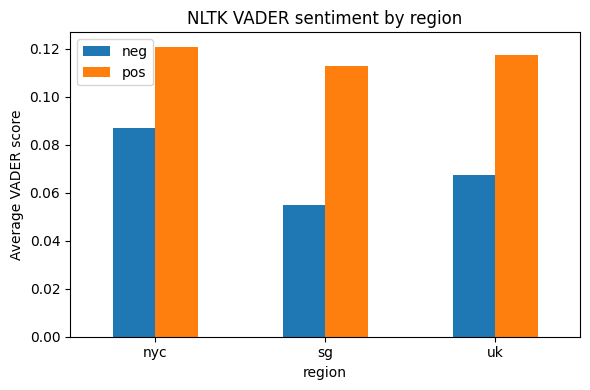

In [97]:
ax = vader_region[["neg", "pos"]].plot(kind="bar", figsize=(6, 4))
ax.set_ylabel("Average VADER score")
ax.set_title("NLTK VADER sentiment by region")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Vader Conclusion:

VADER works by looking up each word in a sentiment dictionary, then tweaking the score based on context: negations like “not”, degree words like “very”, punctuation, all-caps, and some common idioms. For each tweet it gives us a mix of negative / neutral / positive proportions and a single “compound” score between −1 and 1.

In this dataset NYC has both the highest average negative score and the highest positive score, which fits the idea of New York X being a bit more emotionally intense. Singapore has the lowest negative score and the highest average compound score, so its tweets skew the most consistently positive. The UK sits between the two, with less intensity than NYC but slightly more positivity than NYC overall. So VADER’s sentiment view already suggests three different “moods” before we even look at topicsn this dataset NYC has both the highest average negative score and the highest positive score, which fits the idea of New York X being a bit more emotionally intense. Singapore has the lowest negative score and the highest average compound score, so its tweets skew the most consistently positive. The UK sits between the two, with less intensity than NYC but slightly more positivity than NYC overall. So VADER’s sentiment view already suggests three different “moods” before we even look at topicader works by ... 

# 2.B Empath + Dictionary Empath Example

## Step 2.Dictionary_Example - Tiny Dictionary Example of what the **Empath Library** Does

In this we implement the **simplest possible** version of "tweets → numbers." 

First, we load tweets from one region (the UK) and clean the text slightly: convert to lowercase, remove links, newlines, etc. Then, we define a **tiny hand-built dictionary** of categories (`self`, `social`, `work`, `money`, `positive`, and `negative`) each represented by a small list of example words.

For each tweet, we **count** how many words fall into each category, **normalize** by tweet length (to get "words per 100 words"), and finally **average** those values **across** all tweets from that region. 

The result is a short vector of **6 numbers** that describes how often UK tweets talk about themselves, others, work, money, and emotions. 

It’s **small and easy to inspect**, so we can see how the method works **in principle** before scaling up to bigger dictionaries and fancier math.

NYC: 1262 cleaned tweets
SG: 1632 cleaned tweets
UK: 2049 cleaned tweets


,self,social,work,money,positive,negative
NYC,1.757,1.562,0.105,0.102,0.385,0.089
SG,0.850,0.777,0.131,0.092,0.239,0.045
UK,0.988,0.891,0.066,0.067,0.338,0.045


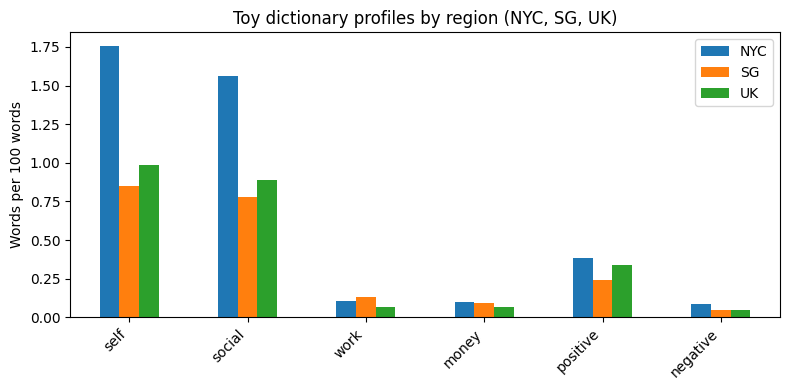

In [78]:
# Tiny dictionary demo for NYC, SG, and UK (same toy dict as before)
TWEETS_DIR = Path("..") / "data" / "tweets"

def clean_text(text: str) -> str:
    """Very simple cleaner: lowercase, strip URLs/@/#, keep letters and spaces."""
    if not text:
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)        # URLs
    text = re.sub(r"[@#]\S+", " ", text)        # @handles and #hashtags
    text = re.sub(r"[^a-z\s]", " ", text)       # non-letters
    text = re.sub(r'&amp;', ' ', text)          # Replaces '&amp;' with a space
    text = re.sub(r"\s+", " ", text).strip()
    return text

toy_dict = {
    "self":     ["i", "me", "my", "mine"],
    "social":   ["you", "we", "friend", "family"],
    "work":     ["work", "job", "office"],
    "money":    ["money", "pay", "bill"],
    "positive": ["good", "great", "love", "happy"],
    "negative": ["bad", "hate", "sad", "angry"]
}

def compute_region_profile(path: Path, label: str) -> pd.Series:
    """Compute average toy-dictionary profile for one region."""
    tweets = []
    with path.open() as f:
        for line in f:
            obj = json.loads(line)
            raw = obj.get("text") or obj.get("tweet_text") or ""
            clean = clean_text(raw)
            if len(clean.split()) >= 5:        # skip super short tweets
                tweets.append(clean)

    print(f"{label}: {len(tweets)} cleaned tweets")

    cat_totals = defaultdict(float)
    tweet_counts = 0

    for txt in tweets:
        words = txt.split()
        if not words:
            continue
        tweet_counts += 1
        for cat, lex in toy_dict.items():
            hits = sum(1 for w in words if w in lex)
            cat_totals[cat] += (hits / len(words)) * 100.0  # "words per 100 words"

    avg_profile = {cat: (cat_totals[cat] / tweet_counts) for cat in toy_dict.keys()}
    return pd.Series(avg_profile, name=label)

profiles = {}

profiles["NYC"] = compute_region_profile(TWEETS_DIR / "nyc_tweets_external.jsonl", "NYC")
profiles["SG"]  = compute_region_profile(TWEETS_DIR / "sg_tweets_external.jsonl",  "SG")
profiles["UK"]  = compute_region_profile(TWEETS_DIR / "uk_tweets_external.jsonl",  "UK")

profiles_df = pd.DataFrame(profiles).T.round(3)
display(profiles_df)

# Bar chart: toy-dictionary profiles by region
ax = profiles_df.T.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Words per 100 words")
ax.set_title("Toy dictionary profiles by region (NYC, SG, UK)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Relative toy dictionary profiles (row sums ≈ 100%):


,self,social,work,money,positive,negative
NYC,43.9,39.1,2.6,2.6,9.6,2.2
SG,39.8,36.4,6.1,4.3,11.2,2.1
UK,41.3,37.2,2.8,2.8,14.1,1.9


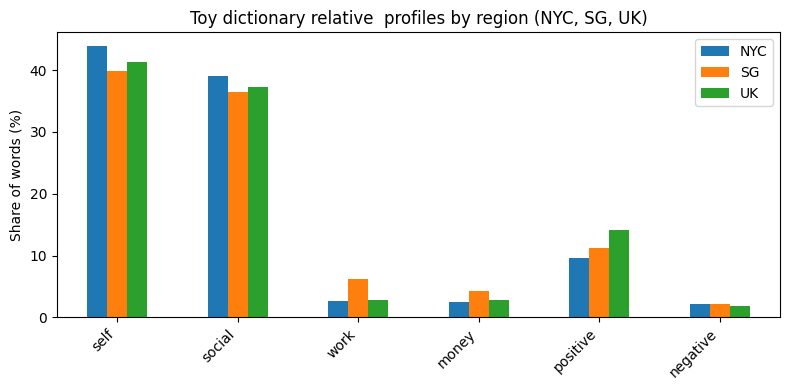

In [79]:
# Relative toy dictionary profiles in the same grouped-bar style

# 1) Row-wise normalize: each city sums to 100%
#    Interpretation: "of all toy-dictionary words for this city,
#    what % are self vs social vs work vs money vs positive vs negative?"
relative_df = profiles_df.div(profiles_df.sum(axis=1), axis=0) * 100

print("Relative toy dictionary profiles (row sums ≈ 100%):")
display(relative_df.round(1))

# 2) Grouped bar chart (same style as the original, but now % on the y-axis)
ax = relative_df.T.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Share of words (%)")
ax.set_title("Toy dictionary relative  profiles by region (NYC, SG, UK)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Toy Conclusion:
Looking at the raw "words per 100 words" chart, NYC clearly uses more of almost every toy dictionary word then SG or the UK. New Yorkers talk about self and social terms roughly twice as often and also edge ahead on positive and negative emotion words, suggesting the more direct talk that the NYC is known for. 
When we convert these to relative percentages, though, the three cities look mucn more similiar: around 80% of their toy-dictionary words are split between self and social. A small slice goes to work and money. What is intresting is that in these relative slices we see that Singapore talks more then 2x more about work and 1.5x more about money then NYC and the UK.

## 2.B.1 Empath Simple

Empath is a more advanced topic / personality dictionary of our toy example. Instead of just telling us whether a tweet is positive or negative, it estimates how much it talks about things like work, money, family, politics, violence, and dozens of other themes. The library ships with a large set of pre-built categories (each one is basically a curated word list). In this notebook we only use those built-in categories and do not create any new ones.

In code, we pass each cleaned tweet to `lexicon.analyze(..., categories=..., normalize=True)`, which returns a score between 0 and 1 for each chosen cetegory i.e. “what fraction of this tweet belongs to this theme?”. We then average those scores by region to get a simple topic profile for NYC, Singapore, and the UK.

In [80]:
# Step 2.A.1 – Empath setup (topic/personality dictionary)
# official git of empath https://github.com/Ejhfast/empath-client


lexicon = Empath()

# Small subset of Empath categories for 2.A (interpretable, not overwhelming)
empath_categories_small = [
    "work",
    "money",
    "family",
    "friends",
    "health",
    "politics",
    "violence",
]

print(f"Using {len(empath_categories_small)} Empath categories:", empath_categories_small)

Using 7 Empath categories: ['work', 'money', 'family', 'friends', 'health', 'politics', 'violence']


In [81]:
from tqdm import tqdm
tqdm.pandas()

def add_empath_features(df: pd.DataFrame, categories: list[str]) -> pd.DataFrame:
    """
    Add Empath features for each tweet in `text_clean`.
    normalize=True → each score ~ fraction of text belonging to that category.
    """
    feats = df["text_clean"].progress_apply(
        lambda txt: lexicon.analyze(txt, categories=categories, normalize=True)
    )
    feats_df = pd.DataFrame(feats.to_list())
    return pd.concat([df.reset_index(drop=True), feats_df], axis=1)

def empath_by_region(df_with_feats: pd.DataFrame, categories: list[str]) -> pd.DataFrame:
    """
    Average Empath category scores per region.
    """
    return (
        df_with_feats
        .groupby("region")[categories]
        .mean()
        .sort_index()
    )


# Apply to tweets_df
tweets_with_empath_small = add_empath_features(tweets_df, empath_categories_small)
empath_region_small = empath_by_region(tweets_with_empath_small, empath_categories_small)

print("Average Empath (small subset) scores per region:")
display(empath_region_small.round(4))

100%|████████████████████████████████████████| 4943/4943 [00:00<00:00, 15536.45it/s]

Average Empath (small subset) scores per region:


,work,money,family,friends,health,politics,violence
region,,,,,,,
nyc,0.0050,0.0045,0.0043,0.0056,0.0019,0.0054,0.0037
sg,0.0064,0.0170,0.0030,0.0027,0.0019,0.0029,0.0029
uk,0.0046,0.0062,0.0047,0.0054,0.0043,0.0019,0.0074


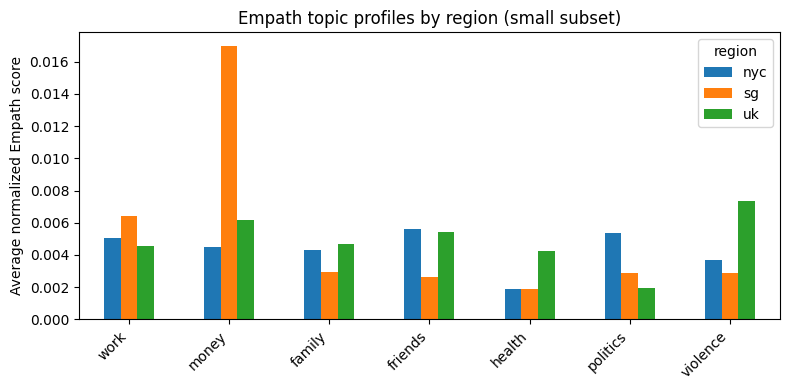

In [82]:
ax = empath_region_small.T.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Average normalized Empath score")
ax.set_title("Empath topic profiles by region (small subset)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Empath Simple Conclusion
Empath lets us ask “what are people talking about” instead of “are they happy or sad.” Using just a few categories (work, money, family, friends, health, politics, violence), it counts how much each theme appears in tweets from each city. In this run, SG leans more toward money, NYC is a bit heavier on friends and politics, and the UK shows more violence words. The categories are few so we are going to do more categories below.

## 2.B.3 Empath Extended

In [83]:
from tqdm import tqdm
tqdm.pandas()

def add_empath_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add Empath features for each tweet in `text_clean`.
    normalize=True → each score ~ fraction of text belonging to that category.
    """
    feats = df["text_clean"].progress_apply(
        lambda txt: lexicon.analyze(txt, normalize=True)
    )
    feats_df = pd.DataFrame(feats.to_list())
    return pd.concat([df.reset_index(drop=True), feats_df], axis=1)

def empath_by_region(df_with_feats: pd.DataFrame) -> pd.DataFrame:
    """
    Average Empath category scores per region.
    Only keep numeric columns when computing the mean.
    """
    # keep only numeric columns (all empath features + any numeric metadata)
    num_cols = df_with_feats.select_dtypes(include="number").columns

    return (
        df_with_feats
        .groupby("region")[num_cols]
        .mean()
        .sort_index()
    )

# Apply to tweets_df
tweets_with_empath = add_empath_features(tweets_df)

# NOTE: use tweets_with_empath (not tweets_with_empath_small)
empath_region = empath_by_region(tweets_with_empath)

print("Average Empath scores per region:")
display(empath_region.round(4))


100%|██████████████████████████████████████████| 4943/4943 [00:16<00:00, 292.99it/s]


Average Empath scores per region:


,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
region,,,,,,,,,,,,,,,,,,,,,
nyc,0.0025,0.0033,0.0016,0.0045,0.0036,0.0039,0.0028,0.0019,0.0019,0.0029,...,0.0018,0.0056,0.0008,0.0015,0.0066,0.0009,0.0033,0.0024,0.0079,0.0067
sg,0.0033,0.0035,0.0018,0.0170,0.0035,0.0024,0.0013,0.0013,0.0015,0.0011,...,0.0017,0.0020,0.0007,0.0027,0.0053,0.0008,0.0045,0.0029,0.0047,0.0031
uk,0.0017,0.0023,0.0059,0.0062,0.0038,0.0018,0.0041,0.0046,0.0012,0.0015,...,0.0016,0.0036,0.0007,0.0019,0.0047,0.0009,0.0048,0.0058,0.0058,0.0086


In [84]:
# Empath region matrix: rows = [nyc, sg, uk], columns = empath categories
empath_region.shape, empath_region.index, empath_region.columns[:5]

((3, 194),
 Index(['nyc', 'sg', 'uk'], dtype='object', name='region'),
 Index(['help', 'office', 'dance', 'money', 'wedding'], dtype='object'))

In [115]:
# Getting the N most talked categories for the regions
TOP_N = 15

for region in empath_region.index:
    top = empath_region.loc[region].sort_values(ascending=False).head(TOP_N)
    # print(f"\nTop {TOP_N} Empath categories for {region.upper()}:")
    # display(top.to_frame(name="avg_score").round(4))

In [116]:
def graph_top_region(region, TOP_N=15):
    top_region = empath_region.loc[region].sort_values(ascending=False).head(TOP_N)
    
    ax = top_region.plot(kind="barh", figsize=(6, 5))
    ax.invert_yaxis()
    ax.set_xlabel("Average normalized Empath score")
    ax.set_title(f"Top {TOP_N} Empath categories – {region.upper()}")
    plt.tight_layout()
    plt.show()


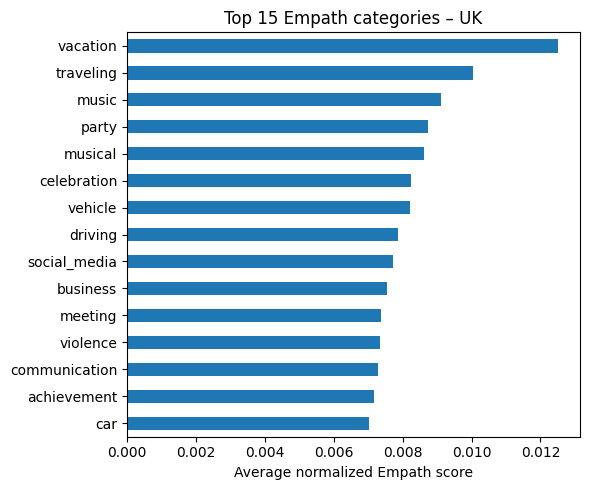

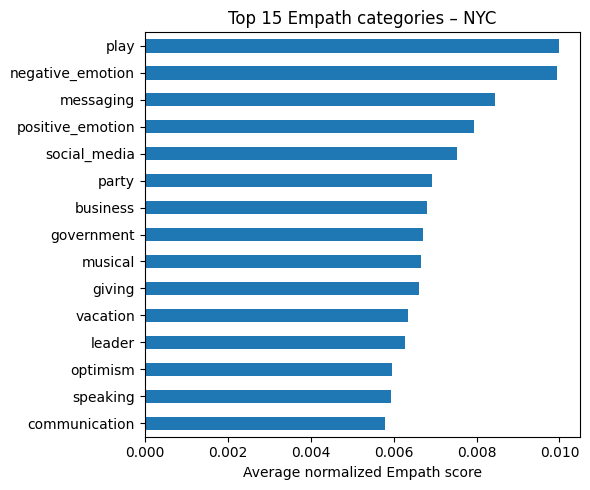

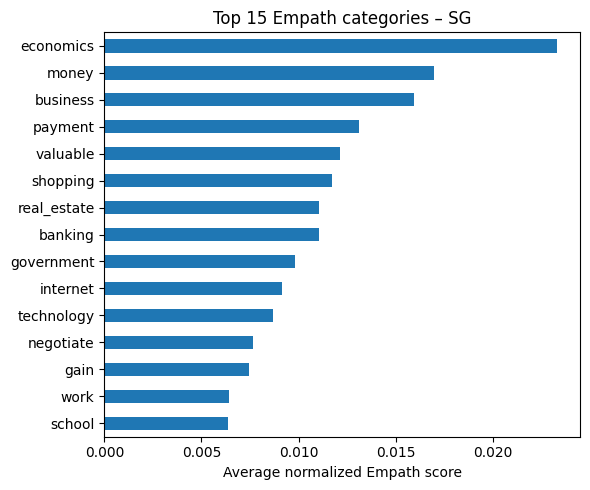

In [117]:
graph_top_region("uk")
graph_top_region("nyc")
graph_top_region("sg")

In [119]:
# Max difference across regions for each category
diff = (empath_region.max(axis=0) - empath_region.min(axis=0))
top_diff = diff.sort_values(ascending=False).head(20)

# print("Categories where regions differ the most:")
# display(top_diff.to_frame(name="max_diff").round(4))

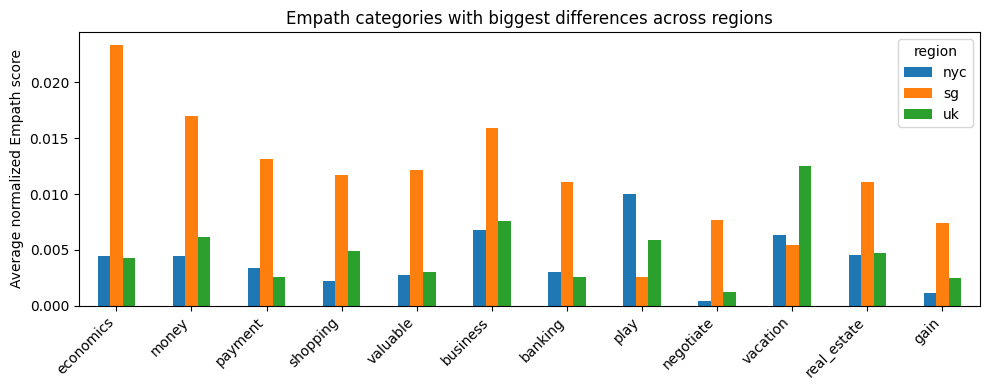

In [120]:
TOP_K = 12
diff_cats = top_diff.index[:TOP_K]

subset = empath_region[diff_cats]

ax = subset.T.plot(kind="bar", figsize=(10, 4))
ax.set_ylabel("Average normalized Empath score")
ax.set_title("Empath categories with biggest differences across regions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [91]:
# Numeric empath columns (exclude id/text/etc.)
empath_cols = tweets_with_empath.select_dtypes(include="number").columns

X = tweets_with_empath[empath_cols].values
y = tweets_with_empath["region"].values

Explained variance: [0.03314976 0.02874146]


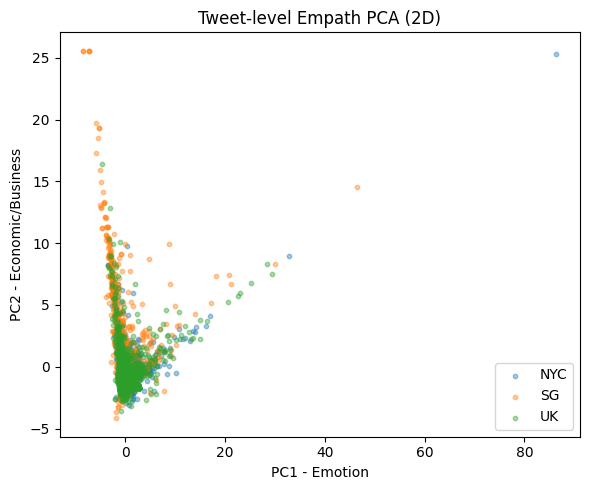

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1 - Emotion": X_pca[:, 0],
    "PC2 - Economic/Business": X_pca[:, 1],
    "region": y,
})

print("Explained variance:", pca.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
for region in pca_df["region"].unique():
    mask = pca_df["region"] == region
    plt.scatter(
        pca_df.loc[mask, "PC1 - Emotion"],
        pca_df.loc[mask, "PC2 - Economic/Business"],
        label=region.upper(),
        alpha=0.4,
        s=10,
    )

plt.xlabel("PC1 - Emotion")
plt.ylabel("PC2 - Economic/Business")
plt.title("Tweet-level Empath PCA (2D)")
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
loadings = pd.DataFrame(
    pca.components_,
    columns=empath_cols,
    index=["PC1", "PC2"]
)

#limited to 7 because its flat and didn't want to take up too much visiual space
for pc in ["PC1", "PC2"]:
    top = loadings.loc[pc].sort_values(key=abs, ascending=False).head(7)
    print(f"\nTop 7 loadings for {pc}:")
    display(top.to_frame(name="loading").round(3))


Top 7 loadings for PC1:


,loading
sadness,0.283
nervousness,0.268
joy,0.267
contentment,0.256
zest,0.254
fear,0.243
sympathy,0.238



Top 7 loadings for PC2:


,loading
economics,0.337
money,0.328
payment,0.319
valuable,0.308
banking,0.300
negotiate,0.274
real_estate,0.236


In [122]:

# Optionally subsample for speed/plotting clarity
# e.g., max 5000 tweets total (rough example)
MAX_POINTS = 5000
if len(tweets_with_empath) > MAX_POINTS:
    tweets_sampled = (
        tweets_with_empath
        .groupby("region", group_keys=False)
        .apply(lambda g: g.sample(n=min(len(g), MAX_POINTS // 3), random_state=42))
        .reset_index(drop=True)
    )
else:
    tweets_sampled = tweets_with_empath.copy()

print("Tweets used for UMAP:", len(tweets_sampled))

# Rebuild X_scaled and y on the sampled set
empath_cols = tweets_sampled.select_dtypes(include="number").columns
X = tweets_sampled[empath_cols].values
y = tweets_sampled["region"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP to 2D on Empath feature space
umap_model = UMAP(
    n_neighbors=15,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)

X_umap = umap_model.fit_transform(X_scaled)

umap_df = pd.DataFrame({
    "UMAP1": X_umap[:, 0],
    "UMAP2": X_umap[:, 1],
    "region": y,
})

umap_df.head()

Tweets used for UMAP: 4943


/Users/user/py-neuro-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP1,UMAP2,region
0,-22.211523,-7.713152,nyc
1,-22.160896,-7.752730,nyc
2,-21.479282,-7.625214,nyc
3,-25.934643,-11.765186,nyc
4,-22.268871,-9.245776,nyc


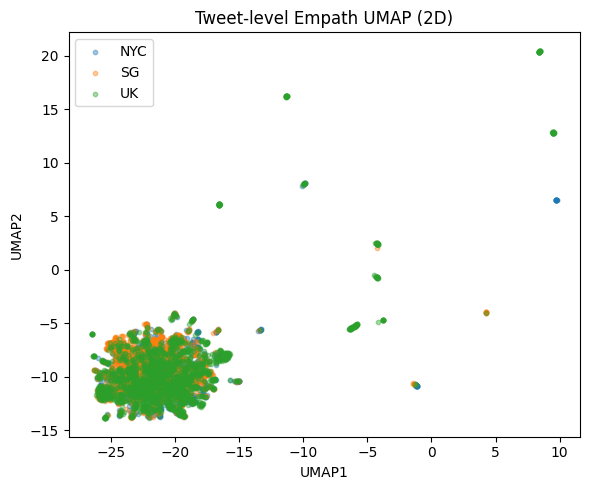

In [123]:
plt.figure(figsize=(6, 5))

for region in sorted(umap_df["region"].unique()):
    mask = umap_df["region"] == region
    plt.scatter(
        umap_df.loc[mask, "UMAP1"],
        umap_df.loc[mask, "UMAP2"],
        label=region.upper(),
        alpha=0.4,
        s=10,
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Tweet-level Empath UMAP (2D)")
plt.legend()
plt.tight_layout()
plt.show()

## Epmath Extended Conclusion
Using the full Empath dictionary plus PCA and UMAP the tweets separate into two main axes: one that is mostly emotional categories (sadness, joy, fear, sympathy) and one that is mostly economic or business categories (economics, money, payment, banking, real_estate). On this map, SG tweets sit higher on the economic axis and look more finance and work focused. NYC tweets spread out more along the emotional axis, with stronger variation in feelings and social mood. UK tweets land between them, with a small tilt toward leisure categories like travel, vacation, and music. All three regions overlap heavily, but their average positions in this Empath space line up with the simpler dictionary and bar chart results.onclusion paragraph:

SG tweets sit higher on the economic axis.

NYC tweets spread more along the emotional axis.

UK tweets land between them, with a tilt toward categories like travel and music.

All three overlap, but their average positions differ in a way that matches the dictionary view.

# Overall Conclusion

Overall, this notebook builds a small but complete data pipeline and analysis to peek into how different cities use X. We start by finding local accounts for each region with the X API, then pull a sample of their tweets, clean the text, and pass everything through two types of lexical tools: a sentiment dictionary (VADER) and a large topic dictionary (Empath). On top of that, we use PCA and UMAP to compress the many Empath categories into a couple of dimensions so that patterns are easier to see.

Across all methods, the main picture is consistent. NYC tweets in this slice look more emotional and socially expressive, with slightly stronger swings in both positive and negative sentiment. SG tweets talk more about money, work, economics, payments, and technology, which matches the image of a finance and business hub. UK tweets sit between the two, with some focus on travel, music, and going out, and sentiment patterns that are close to the global average.

This is not a definitive map of “national character.” The data volume is modest and extraction methods could be considered skewed. We did not check or remove extrememes, we did not make sure that each category is equally represented in the regions from the seed, and we are only getting data from a source. Furthormore, everything is in English, and dictionary methods miss a lot of nuance, irony, and local slang. What it does show is that with a few pages of code and public tools, it is possible to build a reproducible, region level “personality profile” based on how people actually tweet, then compare places in a way that is transparent and easy to extend in future work.